# Step 1: Read in data sets

The `INPUT_LOAD_AND_VRE_FILENAME` refers to a CSV file that contains data with the following columns:
* Timestamp (at hourly level)
* Load on the Island of Amerigo 
* Aggregated solar generation from all proposed PV sites (compiled from SAM)
* Wind generation from proposed site (compiled from SAM)

In [7]:
import os
from openpyxl import load_workbook
import pandas as pd
from datetime import timedelta

BASE_DIR = os.path.dirname(os.path.dirname(os.path.abspath('')))
DATA_DIR = os.path.join(BASE_DIR, 'amerigo_island', 'data')
RAW_DATA_DIR = os.path.join(DATA_DIR, 'raw')
INTERIM_DATA_DIR = os.path.join(DATA_DIR, 'interim')

INPUT_LOAD_AND_VRE_FILENAME = 'load_and_vre.csv'
FINAL_LOAD_AND_VRE_FILENAME = 'final_load_and_vre.csv' # filename of CSV after adding columns

In [8]:
# all input columns as variables for later use
date_colname = 'date'
orig_load_colname = 'load_before_transmission_mw'
solar_gen_colname = 'solar_mw'
wind_gen_colname = 'wind_mw'

load_and_vre_df = pd.read_csv(os.path.join(RAW_DATA_DIR, INPUT_LOAD_AND_VRE_FILENAME))
input_cols = [date_colname, orig_load_colname, wind_gen_colname, solar_gen_colname]
load_and_vre_df = load_and_vre_df.iloc[:, [i for i in range(len(input_cols))]]
load_and_vre_df.columns = input_cols

#### Column Names
The below lists all of the columns that we'll create from our input data set, listed as variables

In [60]:
# all derived columns as variables for later use

### COMMON - columns needed bt legacy gen, batteries, hydrogen
day_of_month_colname = 'day_of_month'
day_of_yr_colname = 'day_of_yr'
week_of_yr_colname = 'wk_of_yr'
month_colname = 'month'
year_colname = 'year'
load_w_transmission_loss_and_load_scale_colname = 'load_w_transmission_loss_and_load_scale'
total_vre_gen_colname = 'total_vre_gen_mw'
therm_gen_baseline_colname = 'therm_gen_baseline'
load_after_therm_gen_baseline_colname = 'load_after_therm_gen_baseline'
load_after_therm_gen_baseline_and_vre_prod_colname = 'load_after_therm_gen_baseline_and_vre_prod'
curtailment_after_therm_gen_baseline_and_vre_colname = 'curtailment_after_therm_gen_baseline_and_vre' # Post Grid Demand VRE Curtailment

# addtl common cols, tbd on whether we still need
# weekday_colname = 'weekday'
# load_vre_diff_colname = 'load_vre_diff'
# prev_7_load_colname = 'prev_7_load'
# prev_7_load_vre_diff_colname = 'prev_7_load_vre_diff'
# prev_7_vre_gen_colname = 'prev_7_vre_gen'
# critical_load_mw_colname = 'critical_load_mw'
# critical_load_less_vre_colname = 'critical_load_less_vre_mw'
# load_after_thermal_gen_colname = 'load_after_thermal_gen'
# surplus_vre_colname = 'surplus_vre'

### BATTERIES 
battery_soc_colname = 'battery_soc_mwh'
curtailment_after_battery_charge_colname = 'curtailment_after_battery_charge'
thermal_gen_delta_from_baseline_colname = 'thermal_gen_delta_from_baseline'
battery_discharge_mw_colname = 'battery_discharge_mw' # Battery Production, MW 
battery_curtailment_after_charge_mw_colname = 'battery_curtailment_after_charge_mw'
visible_battery_cols = [
    
]

### HYDROGEN
req_hydrogen_kg_colname = 'reqd_hydrogen_kg'
hydrogen_production_kg_colname = 'hydrogen_prod_kg'
hydrogen_production_m3_colname = 'hydrogen_prod_m3'
hydrogen_h2o_demand_l_colname = 'hydrogen_h2o_demand_l'
hydrogen_h2o_demand_m3_colname = 'hydrogen_h2o_demand_m3'
compression_desal_demand_mw_colname = 'compression_desal_demand_mw' 
h2_demand_comp_desal_kg_colname = 'h2_demand_comp_desal_kg'
cuml_h2_storage_kg_colname = 'cuml_h2_storage_kg'
cuml_hydrogen_demand_kg_colname = 'cuml_hydrogen_demand_kg'
cuml_h2_energy_demand_mwh_colname = 'cuml_h2_energy_demand_mwh'
h2_opex_usd_per_kg_colname = 'h2_opex_usd_per_kg'
h2_opex_electrolyzer_colname = 'h2_opex_electrolyzer'
electrolyzer_power_input_mw_colname = 'electrolyzer_power_input_mw'
fuel_cell_power_generation_mw_colname = 'fuel_cell_power_generation_mw'

### BAU - LEGACY GENERATION
thermal_gen_total_mw_colname = 'thermal_gen_total_mw'
thermal_gen_rice_mw_colname = 'thermal_gen_rice_mw'
thermal_gen_combustion_mw_colname = 'thermal_gen_combustion_mw'


#hourly_vre_gen_wo_storage_colname = 'hourly_vre_gen_wo_storage'
#vre_curtailment_after_thermal_base_gen_colname = 'vre_curtailment_after_thermal_base_gen'
# solar_o_and_m_cost_colname = 'solar_o_and_m_cost'
# wind_o_and_m_cost_colname = 'wind_o_and_m_cost'

#### Assumptions

Any variable in all caps represent constants that are either: 
* assumptions based on the literature
* values taken from SAM (e.g., `SOLAR_INSTALLATION_COST_MM`)
* values specified in the assignment PDF

In [88]:
# other values/assumptions needed for the analysis
CRITICAL_LOAD_PERC = (1/3)
SOLAR_SCALE_FACTOR = 1
WIND_SCALE_FACTOR = 1
TRANSMISSION_EFFICIENCY = 1
LOAD_SCALING_FACTOR = 1
THERMAL_BASE_GEN_MW = 31
THERMAL_MIN_GEN_MW = 0

# Battery storage ##################################
BATTERY_CAPACITY_MWH = 220
BATTERY_POWER_MW = 40
BATTERY_EFFICIENCY = 0.875
BATTERY_DEPTH_OF_DISCHARGE = 0.5
BATTERY_MIN_SOC_MWH = (1 - BATTERY_DEPTH_OF_DISCHARGE) * BATTERY_CAPACITY_MWH
BATTERY_POWER_KW = BATTERY_POWER_MW * 1000
BATTERY_CAPEX = ((BATTERY_CAPACITY_MWH * 1000 * 260) + (BATTERY_POWER_MW * 1000 * 530))
BATT_O_AND_M_COST_PER_KW_YR = .025 * (BATTERY_CAPEX / BATTERY_POWER_KW) #(https://www.nrel.gov/docs/fy19osti/73222.pdf)
BATTERY_SOC_BEGINNING_OF_YR = 179.91
#####################################################

# CAPEX #############################################
SOLAR_INSTALLATION_COST_MM = 50.8
WIND_INSTALLATION_COST_MM = 31.2
H2_FUEL_CELL_COST_MM = 4.23 
H2_ELECTROLYZER_COST_MM = 21.12

# H2 Storage 
H2_STORAGE_CAPEX_USD_PER_KG = 700 # Parks, G., Boyd, R., Cornish, J., & Remick, R. (2014). Hydrogen Station Compression, Storage, and Dispensing Technical Status and Costs: Systems Integration. Related Information: Independent Review 
H2_MAX_STORAGE_CAPACITY_KG = 65000
H2_STORAGE_COST_MM = (H2_STORAGE_CAPEX_USD_PER_KG * H2_MAX_STORAGE_CAPACITY_KG)/ 1_000_000
# H2 Compression
H2_COMPRESSION_COST_MM = 7.32
#####################################################

# O & M #############################################
SOLAR_O_AND_M_COST_KW_PER_YR = 9.1 # kW / yr : https://www.nrel.gov/docs/fy19osti/72399.pdf
WIND_O_AND_M_COST_KW_PER_YR = 44 # kW / yr (ATB - https://atb.nrel.gov/electricity/2019/index.html?t=lw)
FUEL_CELL_O_AND_M_COST_MM = .05 * H2_FUEL_CELL_COST_MM * 1_000_000 # of capital cost (https://www.nrel.gov/docs/fy16osti/65856.pdf)
ELECTROLYZER_O_AND_M_COST_KW_PER_YR = 42 #  (https://www.nrel.gov/docs/fy16osti/65856.pdf)
#####################################################

# Hydrogen storage ##################################
H2_COMPRESSION_CAPEX_KG_H2_PER_DAY = 891 # (HyET Hydrogen. (2020). Electrochemical compression - Technology and performance. Retrieved from http://hyet.nl/hydrogen/technology-and-performance/)

ELEC_EFF_H2_FUEL_CELL_KWH_PER_KG = 19.988333333333
ELEC_EFF_ELECTROLYSIS_KWH_PER_KG = 55.4307635

ENERGY_CONSUMPTION_H2O_DESAL_KWH_PER_M3 = 1.8
DENSITY_H2_300BAR_KG_PER_M3 = 20
DENSITY_H2_30BAR_KG_PER_M3 = 2.38
H2O_ELECTROLYSIS_CONSUMPTION_L_PER_M3 = 1.4

DENSITY_H2_STP_KG_PER_M3 = 0.0813
H2_TAP_WATER_CONSUMPTION_L_PER_M3 = 1.4

ENERGY_CONSUMPTION_H2_KWH_PER_KG = 4
STARTING_H2_IN_STORAGE_KG = 10000
OPEX_H2_USD_PER_KG = 1.08
#####################################################

# Legacy generation options #########################
NOMINAL_HEAT_RATE_BTU_COMBUSTION = 17680
NOMINAL_HEAT_RATE_BTU_RICE = 9827
#####################################################

#### Clean the input data set
The input data set might have `null` values, and we want to make sure the date column is formatted in the way we expect downstream

In [89]:
def clean_input_columns(df):

    cleaned_df = df.copy()
    cleaned_df = cleaned_df.dropna(how='all')

    cleaned_df[date_colname] = pd.to_datetime(cleaned_df[date_colname])
    # all solar vals need to be > 0
    cleaned_df[solar_gen_colname] = cleaned_df[solar_gen_colname]\
        .apply(lambda x: x if x > 0 else 0)
    
    cleaned_df[month_colname] = cleaned_df[date_colname].map(lambda x: x.month)
    cleaned_df[day_of_month_colname] = cleaned_df[date_colname].map(lambda x: x.day)
    cleaned_df[day_of_yr_colname] = cleaned_df[date_colname].map(lambda x: x.timetuple().tm_yday)
    
    return cleaned_df

In [90]:
cleaned_load_and_vre_df = clean_input_columns(load_and_vre_df)

In [91]:
cleaned_load_and_vre_df

,date,load_before_transmission_mw,wind_mw,solar_mw,month,day_of_month,day_of_yr
0,2017-01-01 00:00:00,35.1,1.68,0.0,1,1,1
1,2017-01-01 01:00:00,35.1,1.23,0.0,1,1,1
2,2017-01-01 02:00:00,34.6,1.09,0.0,1,1,1
3,2017-01-01 03:00:00,34.2,1.47,0.0,1,1,1
4,2017-01-01 04:00:00,33.8,1.12,0.0,1,1,1
...,...,...,...,...,...,...,...
8755,2017-12-31 19:00:00,45.5,6.77,0.0,12,31,365
8756,2017-12-31 20:00:00,46.5,6.21,0.0,12,31,365
8757,2017-12-31 21:00:00,45.0,8.73,0.0,12,31,365
8758,2017-12-31 22:00:00,41.7,7.23,0.0,12,31,365


#### Assertions
Since the rows of the input data set are expected to represent hours over one year, we'd expect there to be 8760 rows.

Also check that each day only has 24 rows

In [92]:
assert len(cleaned_load_and_vre_df) == 8760, "Expected one row per hour in year (8760), got {} rows".format(len(load_and_gen_df))

for day_of_yr in cleaned_load_and_vre_df[day_of_yr_colname].unique():
    if len(cleaned_load_and_vre_df[cleaned_load_and_vre_df[day_of_yr_colname] == day_of_yr]) != 24:
        assert ValueError("Day {} has {} values".format(day_of_yr, len(cleaned_load_and_vre_df[cleaned_load_and_vre_df[day_of_yr_colname] == day_of_yr])))
        

Each of the technologies considered for resilience have some columns in common. This function creates these columns for use in the battery case, business-as-usual case, and hydrogen case

In [131]:
def add_common_derived_columns(df):
    
    decorated_df = df.copy()
    
    decorated_df[solar_gen_colname] = \
        decorated_df[solar_gen_colname] \
        * SOLAR_SCALE_FACTOR
    
    decorated_df[wind_gen_colname] = \
        decorated_df[wind_gen_colname] \
        * WIND_SCALE_FACTOR
        
    decorated_df[load_w_transmission_loss_and_load_scale_colname] = \
        decorated_df[orig_load_colname] / \
        (TRANSMISSION_EFFICIENCY * LOAD_SCALING_FACTOR)

    decorated_df[therm_gen_baseline_colname] = THERMAL_BASE_GEN_MW
    
    decorated_df[load_after_therm_gen_baseline_colname] = \
        decorated_df[load_w_transmission_loss_and_load_scale_colname] \
        - decorated_df[therm_gen_baseline_colname]
    
    decorated_df[total_vre_gen_colname] = \
        decorated_df[wind_gen_colname] + decorated_df[solar_gen_colname]
        
    decorated_df[load_after_therm_gen_baseline_and_vre_prod_colname] = \
        (decorated_df[load_after_therm_gen_baseline_colname] \
        - decorated_df[total_vre_gen_colname]).map(lambda x: x if x > 0 else 0)
    
    decorated_df[curtailment_after_therm_gen_baseline_and_vre_colname] = \
        (decorated_df[total_vre_gen_colname] \
        - decorated_df[load_after_therm_gen_baseline_colname]).map(lambda x: x if x > 0 else 0)
    
#     decorated_df[critical_load_mw_colname] = \
#         decorated_df[load_w_transmission_loss_and_load_scale_colname] * CRITICAL_LOAD_PERC
    
#     decorated_df[critical_load_less_vre_colname] = \
#         decorated_df[critical_load_mw_colname] - decorated_df[total_vre_gen_colname]
    
#     decorated_df[surplus_vre_colname] = \
#         -decorated_df[critical_load_less_vre_colname]
    
#     decorated_df[load_vre_diff_colname] = \
#         decorated_df[load_w_transmission_loss_and_load_scale_colname] \
#         - decorated_df[total_vre_gen_colname]
    
#     decorated_df[load_vre_diff_colname] = decorated_df[load_vre_diff_colname]\
#         .map(lambda x: x if x > 0 else 0)
    
#     decorated_df[critical_load_less_vre_colname] = decorated_df[critical_load_less_vre_colname]\
#         .map(lambda x: x if x > 0 else 0)

#     decorated_df[surplus_vre_colname] = decorated_df[surplus_vre_colname]\
#         .map(lambda x: x if x > 0 else 0)

    
#     decorated_df[vre_curtailment_after_thermal_base_gen_colname] = \
#         - decorated_df[remaining_load_after_vre_prod_colname]
    
#     decorated_df[remaining_load_after_vre_prod_colname] = decorated_df[remaining_load_after_vre_prod_colname] \
#         .map(lambda x: x if x > 0 else 0)
    
#     decorated_df[vre_curtailment_after_thermal_base_gen_colname] = decorated_df[vre_curtailment_after_thermal_base_gen_colname] \
#         .map(lambda x: x if x > 0 else 0)
    
#     decorated_df[hourly_vre_gen_wo_storage_colname] = decorated_df.apply(
#         lambda x: x[total_vre_gen_colname] if x[total_vre_gen_colname] <= x[critical_load_mw_colname] else x[critical_load_mw_colname],
#         axis=1
#     )
    

    return decorated_df

In [94]:
final_load_and_vre_df = add_common_derived_columns(cleaned_load_and_vre_df)

# drop the CSV within the project
final_load_and_vre_df.to_csv(os.path.join(INTERIM_DATA_DIR, FINAL_LOAD_AND_VRE_FILENAME), index=False)

In [96]:
final_load_and_vre_df.head(10)

,date,load_before_transmission_mw,wind_mw,solar_mw,month,day_of_month,day_of_yr,load_w_transmission_loss_and_load_scale,therm_gen_baseline,load_after_therm_gen_baseline,total_vre_gen_mw,load_after_therm_gen_baseline_and_vre_prod,curtailment_after_therm_gen_baseline_and_vre
0,2017-01-01 00:00:00,35.1,1.68,0.0000,1,1,1,35.1,31,4.1,1.6800,2.42,0.0000
1,2017-01-01 01:00:00,35.1,1.23,0.0000,1,1,1,35.1,31,4.1,1.2300,2.87,0.0000
2,2017-01-01 02:00:00,34.6,1.09,0.0000,1,1,1,34.6,31,3.6,1.0900,2.51,0.0000
3,2017-01-01 03:00:00,34.2,1.47,0.0000,1,1,1,34.2,31,3.2,1.4700,1.73,0.0000
4,2017-01-01 04:00:00,33.8,1.12,0.0000,1,1,1,33.8,31,2.8,1.1200,1.68,0.0000
5,2017-01-01 05:00:00,33.4,0.91,0.0000,1,1,1,33.4,31,2.4,0.9100,1.49,0.0000
6,2017-01-01 06:00:00,33.3,1.84,0.0000,1,1,1,33.3,31,2.3,1.8400,0.46,0.0000
7,2017-01-01 07:00:00,33.8,1.59,6.8978,1,1,1,33.8,31,2.8,8.4878,0.00,5.6878
8,2017-01-01 08:00:00,34.7,1.18,21.3585,1,1,1,34.7,31,3.7,22.5385,0.00,18.8385
9,2017-01-01 09:00:00,34.7,0.78,27.9603,1,1,1,34.7,31,3.7,28.7403,0.00,25.0403


# Battery Analysis

Using the data set above, we can create a battery-specific analysis from the observed data.

This function takes in the hourly data and a config that contains properties of a battery. 

In [135]:
battery_capacity_mwh_config_prop = "battery_capacity_mwh"
battery_power_mw_config_prop = "battery_power_mw"
battery_efficiency_config_prop = "battery_efficiency"

def add_battery_cols(hourly_df, battery_config):
    
    decorated_df = hourly_df.copy()
    
    battery_capacity = battery_config[battery_capacity_mwh_config_prop]
    battery_efficiency = battery_config[battery_efficiency_config_prop]
    
    decorated_df[battery_soc_colname] = None
    decorated_df[curtailment_after_battery_charge_colname] = None
    decorated_df[battery_discharge_mw_colname] = None

    decorated_df.reset_index()
    for idx, row in decorated_df.iterrows():

        if idx == 0: # First row of data set, so can't take previous hour's values
            
            soc_val = \
                BATTERY_SOC_BEGINNING_OF_YR \
                - (row[load_after_therm_gen_baseline_and_vre_prod_colname] \
                / battery_efficiency) \
                + row[curtailment_after_therm_gen_baseline_and_vre_colname]
            
            batt_curtailment_val = BATTERY_SOC_BEGINNING_OF_YR \
                - row[load_after_therm_gen_baseline_and_vre_prod_colname] \
                + row[curtailment_after_therm_gen_baseline_and_vre_colname] \
                - soc_val
            
            discharge_val = BATTERY_SOC_BEGINNING_OF_YR \
                - row[load_after_therm_gen_baseline_and_vre_prod_colname] \
                + row[curtailment_after_therm_gen_baseline_and_vre_colname] \
                - soc_val \
                - batt_curtailment_val
                
        else: # Subsequent rows. Has values for previous hour
            
            prev_soc = decorated_df.loc[idx - 1, battery_soc_colname]
            load_after_therm_gen_baseline_and_vre_prod = row[load_after_therm_gen_baseline_and_vre_prod_colname]
            curtailment_after_therm_gen_baseline_and_vre = row[curtailment_after_therm_gen_baseline_and_vre_colname]
            
            soc_val = prev_soc \
                - (load_after_therm_gen_baseline_and_vre_prod / battery_efficiency)\
                + curtailment_after_therm_gen_baseline_and_vre
            
            soc_val = soc_val if soc_val > BATTERY_MIN_SOC_MWH else BATTERY_MIN_SOC_MWH
            soc_val = soc_val if soc_val < BATTERY_CAPACITY_MWH else BATTERY_CAPACITY_MWH
            
            batt_curtailment_val = prev_soc \
                - load_after_therm_gen_baseline_and_vre_prod \
                + curtailment_after_therm_gen_baseline_and_vre \
                - soc_val
            
            batt_curtailment_val = batt_curtailment_val if batt_curtailment_val > 0 else 0
            
            discharge_val = (prev_soc - soc_val) if (prev_soc - soc_val) > 0 else 0
        
        decorated_df.at[idx, battery_soc_colname] = soc_val
        decorated_df.at[idx, curtailment_after_battery_charge_colname] = batt_curtailment_val
        decorated_df.at[idx, battery_discharge_mw_colname] = discharge_val

    decorated_df[battery_soc_colname] = decorated_df[battery_soc_colname].astype(float)
    decorated_df[curtailment_after_battery_charge_colname] = decorated_df[curtailment_after_battery_charge_colname].astype(float)
    decorated_df[battery_discharge_mw_colname] = decorated_df[battery_discharge_mw_colname].astype(float)

    decorated_df[thermal_gen_delta_from_baseline_colname] = -decorated_df[curtailment_after_battery_charge_colname]
    
    decorated_df[thermal_gen_delta_from_baseline_colname] = decorated_df.apply(
        lambda x: -x[curtailment_after_battery_charge_colname] \
            if x[therm_gen_baseline_colname] - x[curtailment_after_battery_charge_colname] > THERMAL_MIN_GEN_MW  \
            else THERMAL_MIN_GEN_MW , axis=1
    )
    
    return decorated_df

In [136]:
battery_config = {
    battery_capacity_mwh_config_prop : BATTERY_CAPACITY_MWH,
    battery_power_mw_config_prop : BATTERY_POWER_MW,
    battery_efficiency_config_prop : BATTERY_EFFICIENCY
}

In [132]:
battery_hourly_df = add_battery_cols(final_load_and_vre_df, battery_config)

In [133]:
battery_hourly_df

,date,load_before_transmission_mw,wind_mw,solar_mw,month,day_of_month,day_of_yr,load_w_transmission_loss_and_load_scale,therm_gen_baseline,load_after_therm_gen_baseline,total_vre_gen_mw,load_after_therm_gen_baseline_and_vre_prod,curtailment_after_therm_gen_baseline_and_vre,battery_soc_mwh,curtailment_after_battery_charge,battery_discharge_mw,thermal_gen_delta_from_baseline
0,2017-01-01 00:00:00,35.1,1.68,0.0,1,1,1,35.1,31,4.1,1.68,2.42,0.0,177.144286,0.345714,0.000000,-0.345714
1,2017-01-01 01:00:00,35.1,1.23,0.0,1,1,1,35.1,31,4.1,1.23,2.87,0.0,173.864286,0.410000,3.280000,-0.410000
2,2017-01-01 02:00:00,34.6,1.09,0.0,1,1,1,34.6,31,3.6,1.09,2.51,0.0,170.995714,0.358571,2.868571,-0.358571
3,2017-01-01 03:00:00,34.2,1.47,0.0,1,1,1,34.2,31,3.2,1.47,1.73,0.0,169.018571,0.247143,1.977143,-0.247143
4,2017-01-01 04:00:00,33.8,1.12,0.0,1,1,1,33.8,31,2.8,1.12,1.68,0.0,167.098571,0.240000,1.920000,-0.240000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2017-12-31 19:00:00,45.5,6.77,0.0,12,31,365,45.5,31,14.5,6.77,7.73,0.0,203.568914,1.104286,8.834286,-1.104286
8756,2017-12-31 20:00:00,46.5,6.21,0.0,12,31,365,46.5,31,15.5,6.21,9.29,0.0,192.951771,1.327143,10.617143,-1.327143
8757,2017-12-31 21:00:00,45.0,8.73,0.0,12,31,365,45.0,31,14.0,8.73,5.27,0.0,186.928914,0.752857,6.022857,-0.752857
8758,2017-12-31 22:00:00,41.7,7.23,0.0,12,31,365,41.7,31,10.7,7.23,3.47,0.0,182.963200,0.495714,3.965714,-0.495714


#### Below is scratch, disregard

# Hydrogen-specific analysis

In [13]:
def calc_h2_cols(df):
    
    decorated_df = df.copy()
    
    decorated_df[req_hydrogen_kg_colname] = \
        (decorated_df[critical_load_less_vre_colname] * 1000)/ ELEC_EFF_H2_FUEL_CELL_KWH_PER_KG
    
    decorated_df[hydrogen_production_kg_colname] = \
        (decorated_df[surplus_vre_colname] * 1000) / ELEC_EFF_ELECTROLYSIS_KWH_PER_KG
    
    decorated_df[h2_opex_usd_per_kg_colname] = \
        decorated_df[hydrogen_production_kg_colname] * OPEX_H2_USD_PER_KG
    
    decorated_df[hydrogen_production_m3_colname] = \
        decorated_df[hydrogen_production_kg_colname] / DENSITY_H2_30BAR_KG_PER_M3
    
    decorated_df[hydrogen_h2o_demand_l_colname] = \
        decorated_df[hydrogen_production_m3_colname] * H2O_ELECTROLYSIS_CONSUMPTION_L_PER_M3
    
    decorated_df[hydrogen_h2o_demand_m3_colname] = \
        (decorated_df[hydrogen_production_kg_colname] / DENSITY_H2_STP_KG_PER_M3) \
        * (H2_TAP_WATER_CONSUMPTION_L_PER_M3 / 1000)
    
    decorated_df[compression_desal_demand_mw_colname] = \
        (decorated_df[hydrogen_production_kg_colname] * ENERGY_CONSUMPTION_H2_KWH_PER_KG / 1000) \
        + (decorated_df[hydrogen_h2o_demand_m3_colname] * ENERGY_CONSUMPTION_H2O_DESAL_KWH_PER_M3 / 1000)
    
    decorated_df[h2_demand_comp_desal_kg_colname] = \
        (decorated_df[compression_desal_demand_mw_colname] * 1000)/ ELEC_EFF_H2_FUEL_CELL_KWH_PER_KG
    
    decorated_df.sort_values(date_colname)
    
# calc cuml h2 demand
    decorated_df[cuml_hydrogen_demand_kg_colname] = None
    decorated_df[cuml_h2_storage_kg_colname] = None
    decorated_df.reset_index()
    for idx, row in decorated_df.iterrows():
        
        if idx == 0:
            h2_demand_val = row[req_hydrogen_kg_colname]
            h2_storage_val = STARTING_H2_IN_STORAGE_KG \
                - row[req_hydrogen_kg_colname] \
                - row[h2_demand_comp_desal_kg_colname] \
                + row[hydrogen_production_kg_colname]

        else : #
            
            h2_demand_val = \
                decorated_df.loc[idx - 1, cuml_hydrogen_demand_kg_colname] \
                + row[req_hydrogen_kg_colname]\
                - row[hydrogen_production_kg_colname]
            
            h2_storage_val = decorated_df.loc[idx - 1, cuml_h2_storage_kg_colname] \
                - row[req_hydrogen_kg_colname] \
                - row[h2_demand_comp_desal_kg_colname] \
                + row[hydrogen_production_kg_colname]
        
        decorated_df.at[idx, cuml_hydrogen_demand_kg_colname] = h2_demand_val
        decorated_df.at[idx, cuml_h2_storage_kg_colname] = h2_storage_val
    
        
    decorated_df[electrolyzer_power_input_mw_colname] = \
        decorated_df[hydrogen_production_kg_colname] * ELEC_EFF_ELECTROLYSIS_KWH_PER_KG/ 1000
    decorated_df[cuml_h2_energy_demand_mwh_colname] = \
        (decorated_df[cuml_hydrogen_demand_kg_colname] * ELEC_EFF_H2_FUEL_CELL_KWH_PER_KG) / 1000
    decorated_df[fuel_cell_power_generation_mw_colname] = \
        (decorated_df[req_hydrogen_kg_colname] \
        + decorated_df[h2_demand_comp_desal_kg_colname]) \
        * (ELEC_EFF_H2_FUEL_CELL_KWH_PER_KG / 1000)
    
    decorated_df[h2_opex_electrolyzer_colname] = \
        decorated_df[electrolyzer_power_input_mw_colname] * 1000 \
        * ELECTROLYZER_O_AND_M_COST_KW_PER_YR / 8760

    return decorated_df

In [14]:
h2_hourly_df = calc_h2_cols(final_load_and_vre_df)

h2_daily_df = h2_hourly_df.groupby(day_of_yr_colname).sum().reset_index()
h2_daily_df = h2_daily_df.drop([month_colname, day_of_month_colname], axis=1)

# Add common columns to daily DataFrame

In [15]:
def sum_prev_rows(row, df, lookback_colname, agg_colname, days = 7):

    start_idx = row[lookback_colname] - days    
    return_val = df.loc[start_idx:row[lookback_colname] - 1, agg_colname].sum() if start_idx >= 0 else None
    
    return return_val

def add_daily_common_cols(df):
    
    decorated_df = df.copy()

    decorated_df[prev_7_load_colname] = decorated_df\
        .apply(sum_prev_rows, axis=1, args=(decorated_df, day_of_yr_colname, load_w_transmission_loss_and_load_scale_colname,))

    decorated_df[prev_7_load_vre_diff_colname] = decorated_df\
        .apply(sum_prev_rows, axis=1, args=(decorated_df, day_of_yr_colname, load_vre_diff_colname,))

    decorated_df[prev_7_vre_gen_colname] = decorated_df\
        .apply(sum_prev_rows, axis=1, args=(decorated_df, day_of_yr_colname, total_vre_gen_colname,))

    return decorated_df

In [16]:
daily_df = add_daily_common_cols(h2_daily_df)

# Battery-specific analysis

In [18]:
battery_config = {
    battery_capacity_mwh_config_prop : BATTERY_CAPACITY_MWH,
    battery_power_mw_config_prop : BATTERY_POWER_MW
}

In [19]:
battery_hourly_df = add_battery_cols(h2_hourly_df, battery_config)

In [20]:
battery_hourly_df

,date,load_before_transmission_mw,wind_mw,solar_mw,month,day_of_month,day_of_yr,load_w_transmission_loss_and_load_scale,total_vre_gen_mw,critical_load_mw,...,cuml_h2_storage_kg,electrolyzer_power_input_mw,cuml_h2_energy_demand_mwh,fuel_cell_power_generation_mw,h2_opex_electrolyzer,load_after_thermal_base_gen_mw,remaining_load_after_vre_prod_mw,battery_soc_mwh,battery_curtailment,battery_o_and_m
0,2017-01-01 00:00:00,35.1,1.68,0.0,1,1,1,35.1,1.68,11.700000,...,9498.71,0.0,10.02,10.020000,0.0,3.1,1.42,218.58,0.0,7.942922
1,2017-01-01 01:00:00,35.1,1.23,0.0,1,1,1,35.1,1.23,11.700000,...,8974.9,0.0,20.49,10.470000,0.0,3.1,1.87,216.71,0.0,10.460046
2,2017-01-01 02:00:00,34.6,1.09,0.0,1,1,1,34.6,1.09,11.533333,...,8452.43,0.0,30.9333,10.443333,0.0,2.6,1.51,215.20,0.0,8.446347
3,2017-01-01 03:00:00,34.2,1.47,0.0,1,1,1,34.2,1.47,11.400000,...,7955.64,0.0,40.8633,9.930000,0.0,2.2,0.73,214.47,0.0,4.083333
4,2017-01-01 04:00:00,33.8,1.12,0.0,1,1,1,33.8,1.12,11.266667,...,7448.01,0.0,51.01,10.146667,0.0,1.8,0.68,213.79,0.0,3.803653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2017-12-31 19:00:00,45.5,6.77,0.0,12,31,365,45.5,6.77,15.166667,...,-1.04119e+06,0.0,15557.4,8.396667,0.0,13.5,6.73,207.94,0.0,37.644977
8756,2017-12-31 20:00:00,46.5,6.21,0.0,12,31,365,46.5,6.21,15.500000,...,-1.04166e+06,0.0,15566.7,9.290000,0.0,14.5,8.29,199.65,0.0,46.371005
8757,2017-12-31 21:00:00,45.0,8.73,0.0,12,31,365,45.0,8.73,15.000000,...,-1.04197e+06,0.0,15573,6.270000,0.0,13.0,4.27,195.38,0.0,23.884703
8758,2017-12-31 22:00:00,41.7,7.23,0.0,12,31,365,41.7,7.23,13.900000,...,-1.04231e+06,0.0,15579.6,6.670000,0.0,9.7,2.47,192.91,0.0,13.816210


# BAU Analysis

In [21]:
thermal_gen_total_mw_colname = 'thermal_gen_total_mw'
thermal_gen_total_kwh_colname = 'thermal_gen_total_kwh'

'''
values for RICE taken from: https://www.eergy.gov/sites/prod/files/2016/09/f33/CHP-Recip%20Engines.pdf
assumed to be System #5 in paper above, for two reasons:
- System #5 has highest capacity
- System #5 has O&M similar to what is specified in assignment
'''

therm_rice_config = {
    "o_and_m" : .0105, # in cents / kwh
    "nominal_heat_rate_btu" : NOMINAL_HEAT_RATE_BTU_RICE, # in BTU / kWh
    "fuel_cost" : 2.50, # in $ / gallon
    "thermal_efficiency" : .35,
    "electric_efficiency" : .419,
    "total_efficiency" : .769,
    "nominal_heat_rate_gal" : NOMINAL_HEAT_RATE_BTU_RICE / 139_000,
    "column_prepend" : "rice"
}

'''
values for combustion engine taken from: https://www.epa.gov/sites/production/files/2015-07/documents/catalog_of_chp_technologies_section_3._technology_characterization_-_combustion_turbines.pdf
Specifically, Table 3-2. 
Numbers reflect System #1 in paper above, for two reasons:
- System #1 has closest electric heat rate to what is specified in assignment PDF

Annual Tech Baseline - EIA
'''


therm_combustion_config = {
    "o_and_m" : .0046, # in $ / kWh
    "nominal_heat_rate_btu" : NOMINAL_HEAT_RATE_BTU_COMBUSTION, # in BTU / kWh 
    "fuel_cost" : 2.50, # in $ / gallon
    "thermal_efficiency" : .42,
    "electric_efficiency" : .24,
    "total_efficiency" : .657,
    "nominal_heat_rate_gal" : NOMINAL_HEAT_RATE_BTU_COMBUSTION / 139_000,
    "column_prepend" : "combustion"
}

In [22]:
therm_combustion_config

{'o_and_m': 0.0046,
 'nominal_heat_rate_btu': 17680,
 'fuel_cost': 2.5,
 'thermal_efficiency': 0.42,
 'electric_efficiency': 0.24,
 'total_efficiency': 0.657,
 'nominal_heat_rate_gal': 0.12719424460431655,
 'column_prepend': 'combustion'}

In [23]:
therm_rice_config

{'o_and_m': 0.0105,
 'nominal_heat_rate_btu': 9827,
 'fuel_cost': 2.5,
 'thermal_efficiency': 0.35,
 'electric_efficiency': 0.419,
 'total_efficiency': 0.769,
 'nominal_heat_rate_gal': 0.07069784172661871,
 'column_prepend': 'rice'}

In [24]:
def calc_bau_cols(hourly_df, config):
    
    decorated_df = hourly_df.copy()
    efficiency_key = 'total_efficiency'
    
    col_prepend = config['column_prepend']
    o_and_m = config['o_and_m']
    nominal_heat_rate_gal = config['nominal_heat_rate_gal']
    fuel_cost = config['fuel_cost']
    efficiency = config[efficiency_key]
    
    decorated_df[thermal_gen_total_mw_colname] = decorated_df[load_w_transmission_loss_and_load_scale_colname] - decorated_df[total_vre_gen_colname]
    decorated_df[thermal_gen_total_kwh_colname] = decorated_df[thermal_gen_total_mw_colname] * 1000
    
    decorated_df['{}_fuel_cost'.format(col_prepend)] = \
        decorated_df[thermal_gen_total_kwh_colname] \
        * nominal_heat_rate_gal \
        * fuel_cost
    
    decorated_df['{}_o_and_m_cost'.format(col_prepend)] = \
        decorated_df[thermal_gen_total_kwh_colname] * o_and_m
    
    decorated_df['{}_total_cost'.format(col_prepend)] = decorated_df['{}_o_and_m_cost'.format(col_prepend)] + decorated_df['{}_fuel_cost'.format(col_prepend)]
    
    return decorated_df
    

In [25]:
rice_df = calc_bau_cols(battery_hourly_df, therm_rice_config)
full_df = calc_bau_cols(rice_df, therm_combustion_config)

In [26]:
full_df[["rice_fuel_cost", "combustion_fuel_cost"]].sum()

rice_fuel_cost          3.741637e+07
combustion_fuel_cost    6.731672e+07
dtype: float64

In [27]:
full_df.to_csv('full_df.csv', index=False)

In [28]:
opex_cols = [
    h2_opex_electrolyzer_colname, 
    h2_opex_usd_per_kg_colname, 
    "rice_o_and_m_cost", 
    "combustion_o_and_m_cost"       
]

for opex_col in opex_cols:
    print("{} : ${:0,.0f}".format(opex_col, full_df[opex_col].sum()))
    
print("\n--- fixed O&M costs")
print("solar_o_and_m: ${:0,.0f}".format(SOLAR_O_AND_M_COST_KW_PER_YR * 11125))
print("wind_o_and_m: ${:0,.0f}".format(WIND_O_AND_M_COST_KW_PER_YR * 5711))
print("fuel_cell_o_and_m : ${:0,.0f}".format(FUEL_CELL_O_AND_M_COST_MM))
print("battery_o_and_m: ${:0,.0f}".format(BATTERY_CAPEX * .025))


h2_opex_electrolyzer : $359,597
h2_opex_usd_per_kg : $1,461,314
rice_o_and_m_cost : $2,222,823
combustion_o_and_m_cost : $973,808

--- fixed O&M costs
solar_o_and_m: $101,238
wind_o_and_m: $251,284
fuel_cell_o_and_m : $211,500
battery_o_and_m: $1,960,000


# Scratch
##### Unsure if needed. Keeping just in case

In [29]:
resilience_case_load_daynum = \
    daily_df[daily_df[prev_7_load_colname] == daily_df[prev_7_load_colname].max()].to_dict('r')[0][day_of_yr_colname]

resilience_case_vre_load_diff_daynum = \
    daily_df[daily_df[prev_7_load_vre_diff_colname] == daily_df[prev_7_load_vre_diff_colname].max()].to_dict('r')[0][day_of_yr_colname]

resilience_case_max_demand_daynum = \
    final_load_and_vre_df[final_load_and_vre_df[load_w_transmission_loss_and_load_scale_colname] == final_load_and_vre_df[load_w_transmission_loss_and_load_scale_colname].max()].to_dict('r')[0][day_of_yr_colname]


In [30]:
def add_storage_input_cols(df, daynum):
    
    decorated_df = df.copy()
    
    decorated_df = decorated_df[
        (decorated_df[day_of_yr_colname] <= daynum)
        & (decorated_df[day_of_yr_colname] >= daynum - 6)
    ]
    
    decorated_df = decorated_df.reset_index(drop=True)
    
    decorated_df.sort_values(date_colname)
    decorated_df[cuml_load_since_prev_charge_colname] = None
    
    for idx, row in decorated_df.iterrows():
        
        if idx == 0:
            val = row[critical_load_less_vre_colname]
        elif row[critical_load_less_vre_colname] > 0:
            val = decorated_df.loc[idx - 1, cuml_load_since_prev_charge_colname] + row[critical_load_less_vre_colname]
        else:
            val = 0
            
        decorated_df.at[idx, cuml_load_since_prev_charge_colname] = val
        
    return decorated_df

In [31]:
resil_max_week_load_df = add_storage_input_cols(h2_hourly_df, resilience_case_load_daynum)
resil_vre_load_diff_df = add_storage_input_cols(h2_hourly_df, resilience_case_vre_load_diff_daynum)
resil_max_demand_df = add_storage_input_cols(h2_hourly_df, resilience_case_max_demand_daynum)

In [32]:
def calc_soc_cols(df, config):
    
    decorated_df = df.copy()
    batt_energy_mwh = config[batt_energy_mwh_keyname]
    
    decorated_df[battery_soc_colname] = None
    decorated_df.reset_index(drop=True)
    
    for idx, row in decorated_df.iterrows():
        
        if idx == 0:
            val = batt_energy_mwh - row[critical_load_less_vre_colname] + row[charge_surplus_colname]
        else:
            charge = decorated_df.loc[idx - 1, battery_soc_colname] - row[critical_load_less_vre_colname] + row[charge_surplus_colname] 
            val = charge if charge < batt_energy_mwh else batt_energy_mwh
            
        decorated_df.at[idx, battery_soc_colname] = val
    
    return decorated_df

In [33]:
resil_max_week_load_df[base_df_cols]

,date,load_before_transmission_mw,wind_mw,solar_mw,month,day_of_month,day_of_yr,load_w_transmission_loss_and_load_scale,total_vre_gen_mw,critical_load_mw,critical_load_less_vre_mw,surplus_vre,load_vre_diff,load_after_thermal_gen,remaining_load_after_thermal_base_gen_and_vre_prod,vre_curtailment_after_thermal_base_gen
0,2017-08-14 00:00:00,40.8,4.37,0.0,8,14,226,40.8,4.37,13.600000,9.230000,0.0,36.43,8.8,4.43,0.0
1,2017-08-14 01:00:00,39.2,4.74,0.0,8,14,226,39.2,4.74,13.066667,8.326667,0.0,34.46,7.2,2.46,0.0
2,2017-08-14 02:00:00,38.3,5.03,0.0,8,14,226,38.3,5.03,12.766667,7.736667,0.0,33.27,6.3,1.27,0.0
3,2017-08-14 03:00:00,37.5,4.01,0.0,8,14,226,37.5,4.01,12.500000,8.490000,0.0,33.49,5.5,1.49,0.0
4,2017-08-14 04:00:00,37.5,4.81,0.0,8,14,226,37.5,4.81,12.500000,7.690000,0.0,32.69,5.5,0.69,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,2017-08-20 19:00:00,50.3,0.70,0.0,8,20,232,50.3,0.70,16.766667,16.066667,0.0,49.60,18.3,17.60,0.0
164,2017-08-20 20:00:00,50.2,1.54,0.0,8,20,232,50.2,1.54,16.733333,15.193333,0.0,48.66,18.2,16.66,0.0
165,2017-08-20 21:00:00,48.5,0.83,0.0,8,20,232,48.5,0.83,16.166667,15.336667,0.0,47.67,16.5,15.67,0.0
166,2017-08-20 22:00:00,46.6,0.56,0.0,8,20,232,46.6,0.56,15.533333,14.973333,0.0,46.04,14.6,14.04,0.0


# Data Visualization

In [34]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import timedelta
import math

In [35]:
VIZ_DIR = os.path.join(BASE_DIR, "amerigo_island", "visualizations")

resil_max_week_load_df["base_thermal_gen"] = THERMAL_BASE_GEN_MW

In [36]:
plot_cols = [{load_w_transmission_loss_and_load_scale_colname: "PV"}, {"actual_consumption" : "Load"}]

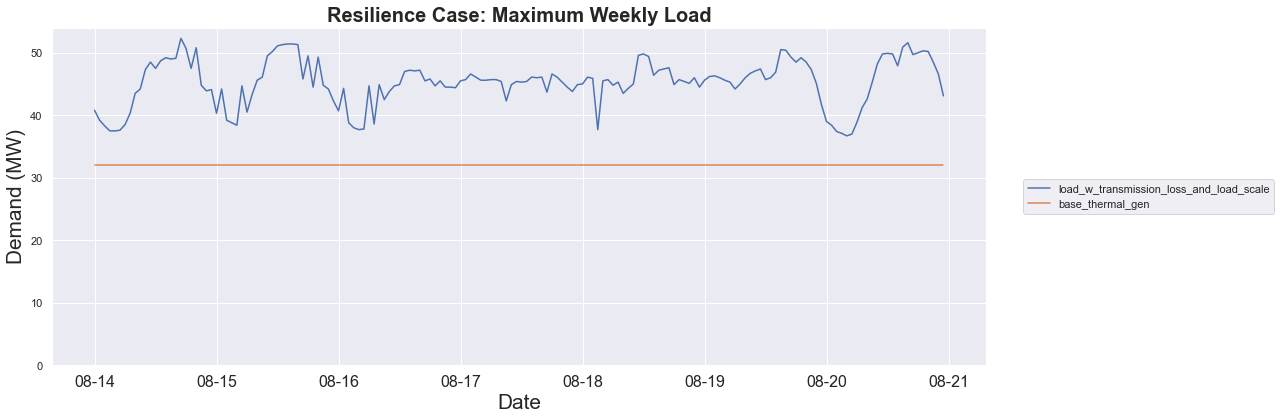

In [55]:
sns.set(rc={'figure.figsize':(18, 6)})
fig = plt.figure()
subplot = fig.add_subplot(1, 1, 1)
subplot.set_ylim([0,54])
plt.plot(date_colname, load_w_transmission_loss_and_load_scale_colname,data=resil_max_week_load_df)
plt.plot(date_colname, "base_thermal_gen", data=resil_max_week_load_df)

subplot.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.ylabel("Demand (MW)", fontsize="xx-large")
plt.xlabel("Date", fontsize="xx-large")
plt.xticks(fontsize=16)
plt.title("Resilience Case: Maximum Weekly Load", fontdict={"fontweight": "bold", "fontsize": 20})

fig.subplots_adjust(top = 0.9, hspace = 0.3)
plt.tight_layout()